In [3]:
# churn_lift_gains_chart_final_save.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# -----------------------------
# 1. Load dataset
# -----------------------------
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


/var/folders/x2/20jtml313cj7ndfpv33kc32r0000gn/T/ipykernel_22606/9563324.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


✅ Charts saved as 'churn_lift_gains_chart.png'


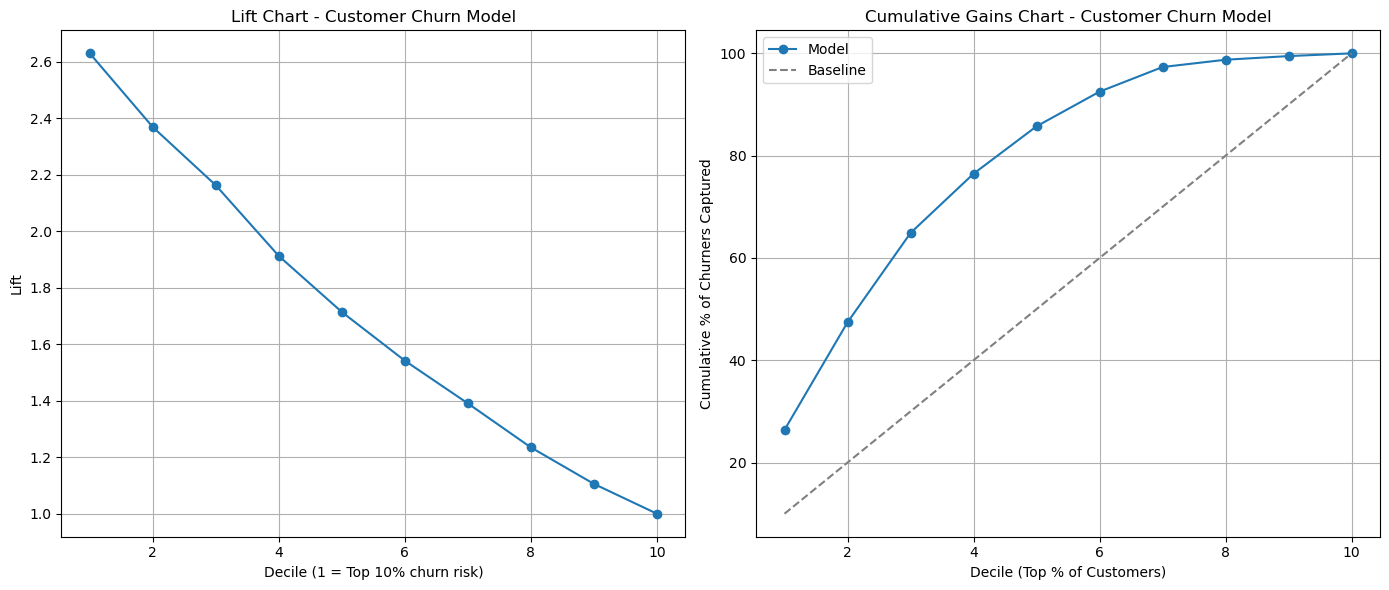


---- MODEL PERFORMANCE METRICS ----
ROC AUC Score:      0.826
Top-Decile Lift:    2.62x
Top-20% Gain:       47.4% of churners captured
-----------------------------------


In [5]:
# -----------------------------
# 2. Preprocessing
# -----------------------------
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# -----------------------------
# 3. Train/test split
# -----------------------------
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -----------------------------
# 4. Train model
# -----------------------------
# model = LogisticRegression(max_iter=1000)
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# -----------------------------
# 5. Build lift & gain table
# -----------------------------
df_lift = pd.DataFrame({'prob': y_pred_prob, 'true': y_test})
df_lift = df_lift.sort_values('prob', ascending=False).reset_index(drop=True)

# Assign deciles correctly: 0 = top churn risk
df_lift['decile'] = pd.qcut(df_lift['prob'].rank(method='first', ascending=False), 10, labels=False)

lift_table = (
    df_lift.groupby('decile', as_index=False)
    .agg(total_customers=('true', 'count'), total_churners=('true', 'sum'))
    .sort_values('decile')
)

lift_table['cum_customers'] = lift_table['total_customers'].cumsum()
lift_table['cum_churners'] = lift_table['total_churners'].cumsum()

total_churners = lift_table['total_churners'].sum()
total_customers = lift_table['total_customers'].sum()

lift_table['gain'] = lift_table['cum_churners'] / total_churners
lift_table['lift'] = lift_table['gain'] / (lift_table['cum_customers'] / total_customers)

# -----------------------------
# 6. Plot Lift and Gains Charts
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# (a) Lift Chart
axes[0].plot(np.arange(1,11), lift_table['lift'], marker='o')
axes[0].set_title("Lift Chart - Customer Churn Model")
axes[0].set_xlabel("Decile (1 = Top 10% churn risk)")
axes[0].set_ylabel("Lift")
axes[0].grid(True)

# (b) Cumulative Gains Chart
axes[1].plot(
    np.arange(1,11),
    lift_table['gain'] * 100,
    marker='o',
    label='Model'
)
axes[1].plot(
    np.arange(1,11),
    np.linspace(10, 100, 10),
    '--',
    color='gray',
    label='Baseline'
)
axes[1].set_title("Cumulative Gains Chart - Customer Churn Model")
axes[1].set_xlabel("Decile (Top % of Customers)")
axes[1].set_ylabel("Cumulative % of Churners Captured")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

# Save both charts
fig.savefig("churn_lift_gains_chart.png", dpi=300)
print("✅ Charts saved as 'churn_lift_gains_chart.png'")

plt.show()

# -----------------------------
# 7. Summary Metrics
# -----------------------------
auc = roc_auc_score(y_test, y_pred_prob)

# Top-decile lift: churn rate in top 10% vs overall
top_decile_cut = len(df_lift) // 10
lift_top10 = df_lift.iloc[:top_decile_cut]['true'].mean() / df_lift['true'].mean()

# Top-20% cumulative gain: fraction of churners captured in top 20%
top_20_cut = len(df_lift) // 5
gain_top20 = df_lift.iloc[:top_20_cut]['true'].sum() / df_lift['true'].sum()

print("\n---- MODEL PERFORMANCE METRICS ----")
print(f"ROC AUC Score:      {auc:.3f}")
print(f"Top-Decile Lift:    {lift_top10:.2f}x")
print(f"Top-20% Gain:       {gain_top20*100:.1f}% of churners captured")
print("-----------------------------------")
